# Assignment to Predict Housing Prices

In [ ]:
!pip install scikit-learn
!pip install lightgbm
!pip install seaborn
!pip install xgboost
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


### Imports

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
from tqdm import tqdm
import json
import pickle
from lightgbm import LGBMRegressor


In [345]:
### Data Import

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target 
df.sample(15)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
4846,2.4500,52.0,3.976271,0.962712,814.0,2.759322,34.02,-118.31,1.114
14922,4.7068,6.0,5.810320,1.059593,4771.0,3.467297,32.62,-116.98,1.843
5329,2.6509,25.0,3.742950,1.159436,3136.0,1.700651,34.05,-118.46,4.100
18726,1.6033,19.0,5.699454,1.114754,505.0,2.759563,40.58,-122.30,0.988
11701,6.2427,11.0,6.161017,1.046610,635.0,2.690678,33.88,-117.97,2.185
7427,2.1406,41.0,3.670270,0.994595,788.0,4.259459,33.95,-118.20,1.653
3504,4.8359,35.0,5.473016,0.987302,992.0,3.149206,34.26,-118.45,1.956
11194,2.5564,6.0,3.650757,1.152503,1894.0,2.204889,33.83,-117.92,1.713
1968,4.0709,13.0,6.119891,1.118529,2093.0,2.851499,38.69,-120.70,1.517
10850,3.2250,21.0,3.935484,1.163594,1099.0,2.532258,33.66,-117.91,1.938


As per publically available information-
- MedInc      -   median income in block group
- HouseAge    -   median house age in block group
- AveRooms    -   average number of rooms in the houses within a block.
- AveBedrms   -   average number of bedrooms in the houses within a block.
- Population  -   total population within a block.
- AveOccup    -   average house occupancy, computed as the total population within a block divided by the number of households.
- Latitude    -   block group latitude
- Longitude   -   block group longitude
- MedHouseVal -   value of house in hundreds of thousands of dollars ($100,000)


---



# EDA

In [270]:
df.shape

(20640, 9)

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [272]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [273]:
df.nunique()

MedInc         12928
HouseAge          52
AveRooms       19392
AveBedrms      14233
Population      3888
AveOccup       18841
Latitude         862
Longitude        844
MedHouseVal     3842
dtype: int64

### Observations
- No missing values in dataset
- No categorical Variables present in our dataset

Now we will do visual Analysis

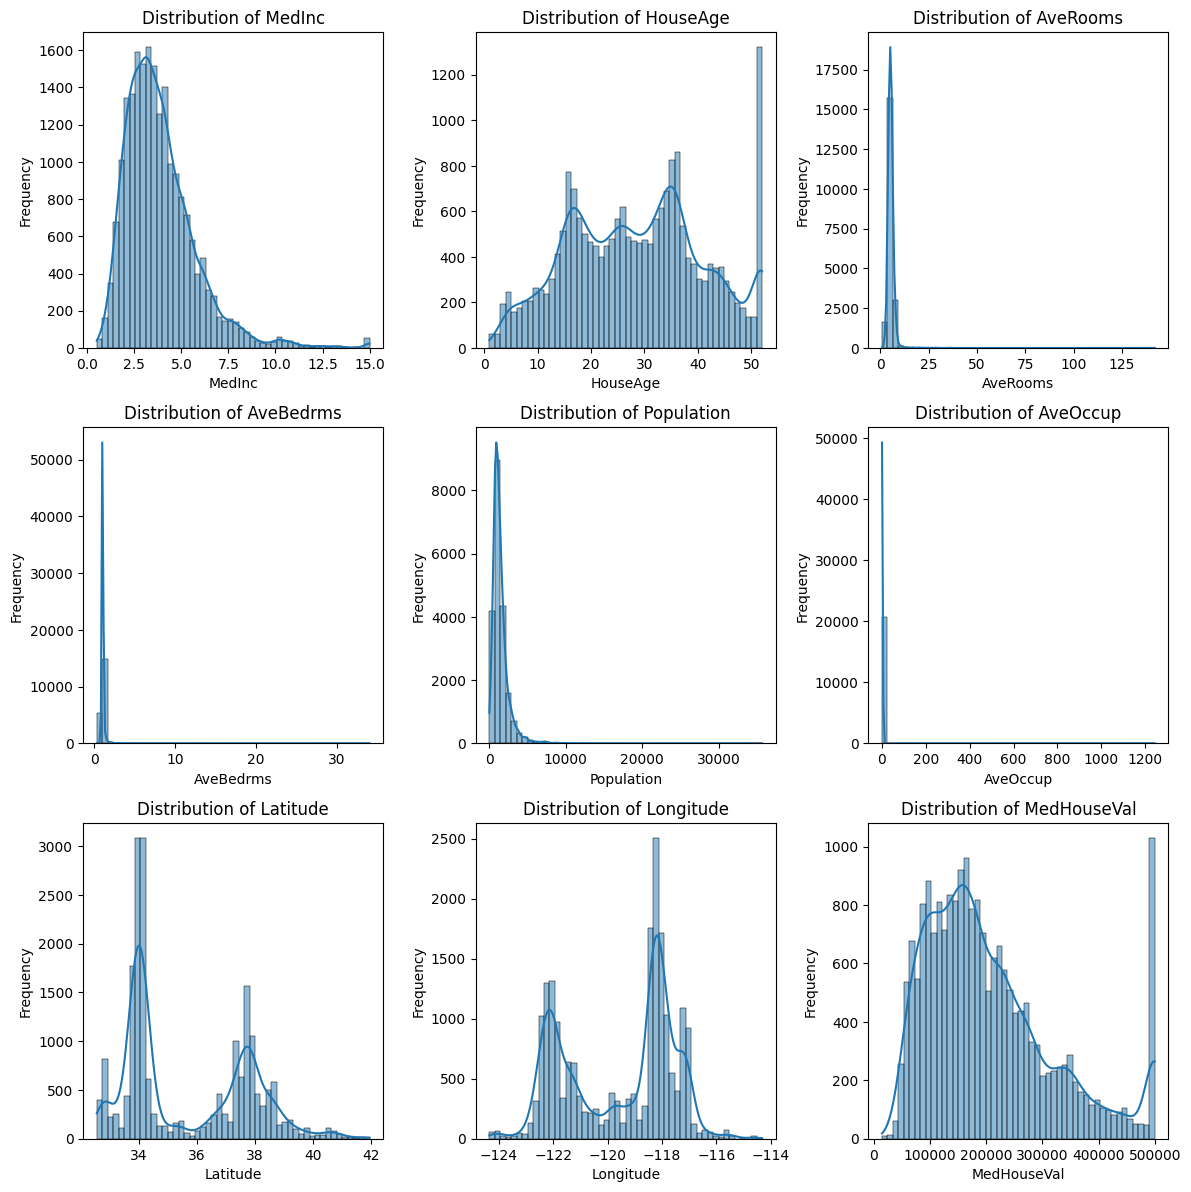

In [192]:
# Create the subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 4 * 3))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distributions
for i, column in enumerate(df.columns):
    sns.histplot(df[column], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

plt.tight_layout(pad=1) 
plt.show()


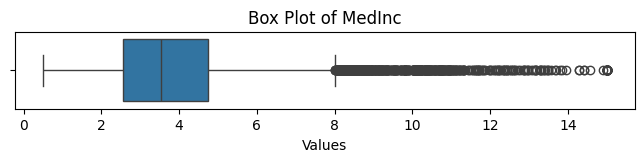

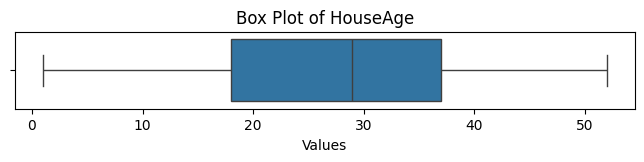

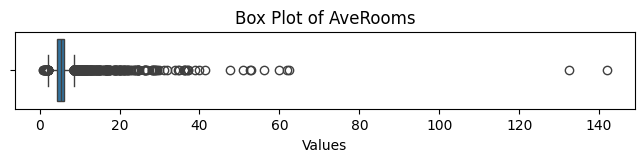

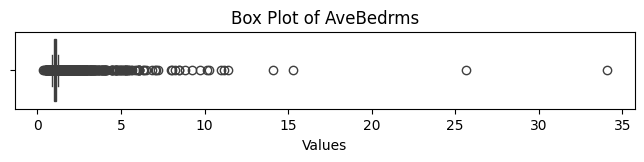

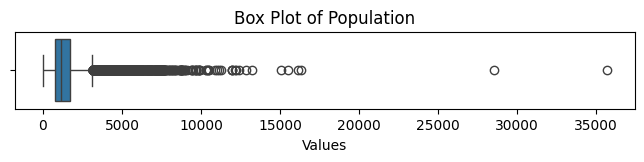

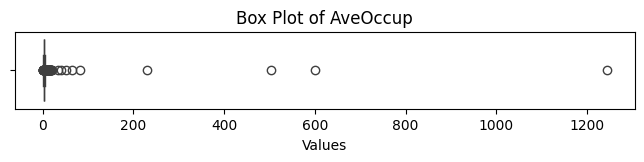

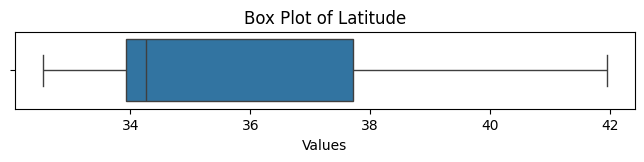

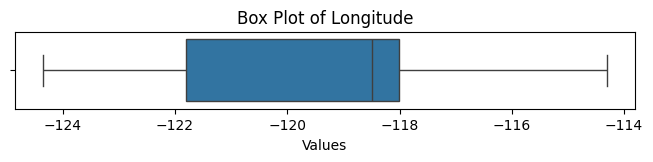

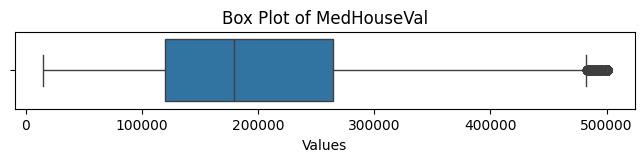

In [193]:
for column in df.columns:
    plt.figure(figsize=(8, 1))
    sns.boxplot(x=df[column])
    # sns.violinplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel('Values')
    plt.show()

### Observations
- Median income has a distribution with a long tail. It means that the median income is more or less normally distributed but there are few people getting a high salary.
- Average House age is more or less uniform. There is a sudden spike when house age is 52 years. There could have been a construction boom 52 years ago.
- Average House Value is more or less uniform but we can also see a threshold effect 
- Average rooms, Average Bedrooms, Average Occupancy and population have a rightly skewed distribution. 

### Outlier detection

In [194]:
# lets look at Average rooms, Average Bedrooms, Average Occupancy and population again
df[['AveRooms','AveBedrms','AveOccup','Population']].describe()
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]

percentile_table = {}

for column in ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']:
    percentile_table[column] = [df[column].quantile(quantile) for quantile in quantiles]

percentile_df = pd.DataFrame(percentile_table, index=[f"{int(q*100)}th Percentile" for q in quantiles])
percentile_df

,AveRooms,AveBedrms,AveOccup,Population
25th Percentile,4.440716,1.006079,2.429741,787.00
50th Percentile,5.229129,1.048780,2.818116,1166.00
75th Percentile,6.052381,1.099526,3.282261,1725.00
90th Percentile,6.961188,1.172727,3.885273,2566.00
95th Percentile,7.640247,1.273006,4.333417,3288.00
99th Percentile,10.357033,2.127541,5.394812,5805.83
100th Percentile,141.909091,34.066667,1243.333333,35682.00


We can clearly see a sudden spike in 99th and 100th percentile values for Average rooms, Average Bedrooms, Average Occupancy and population

Average Bedrooms, Average rooms, Average Population can follow this pattern but average occupancy of more than 25 seems extremely rare

We can further check it by looking at Occupancy per room

In [195]:
df[df['AveOccup']>df['AveOccup'].quantile(0.999)]


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1039,4.3029,16.0,6.090592,1.121951,4930.0,17.177700,38.42,-120.97,121900.0
2511,4.6250,36.0,24.500000,3.500000,28.0,14.000000,36.51,-119.54,162500.0
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,67500.0
4479,3.5769,41.0,4.940000,1.100000,925.0,18.500000,34.07,-118.16,135700.0
5986,1.8750,52.0,4.500000,1.206349,2688.0,21.333333,34.10,-117.71,212500.0
7164,2.1845,36.0,4.812155,1.110497,2862.0,15.812155,34.06,-118.17,123800.0
8874,9.3370,52.0,7.285714,1.214286,1154.0,41.214286,34.06,-118.45,500001.0
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,154600.0
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,162500.0
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,225000.0


In [196]:
df[df['AveBedrms']>df['AveBedrms'].quantile(0.999)]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1102,2.4028,17.0,31.777778,9.703704,47.0,1.740741,40.06,-121.54,67500.0
1239,3.0750,13.0,33.989691,6.824742,267.0,2.752577,38.31,-120.27,108300.0
1240,3.1250,11.0,47.515152,11.181818,82.0,2.484848,38.42,-120.19,77500.0
1872,2.4917,27.0,38.840909,9.272727,97.0,2.204545,38.94,-119.93,200000.0
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16,206300.0
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,437500.0
1914,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10,500001.0
1926,0.9227,11.0,37.000000,8.207547,113.0,2.132075,38.90,-120.30,95500.0
1978,3.5667,13.0,34.843750,7.968750,86.0,2.687500,38.71,-120.32,115600.0
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,162500.0


We can see that AverageRooms and Average Bedrooms are linked. But
- High average occupancy that is more than 15 per household is where average number of rooms are mostly less than 1.5. So it is highly unlikely

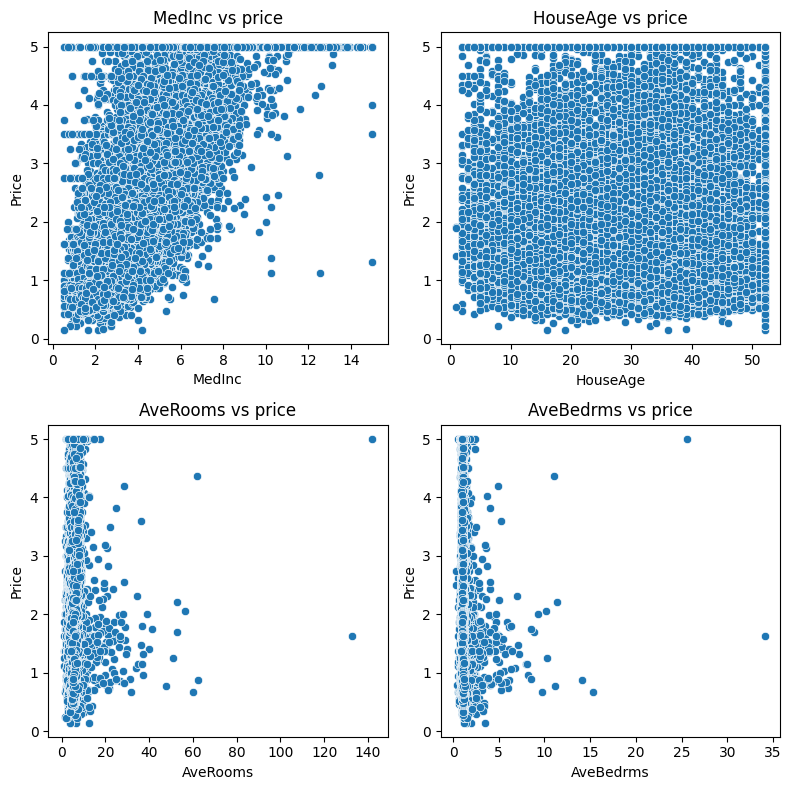

In [274]:

fig, axes = plt.subplots(2, 2, figsize=(8, 4 * 2)) 

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distributions
# Scatterplots of Important Features vs Price
important_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms']
for i, feature in enumerate(important_features):
    sns.scatterplot(x=df[feature], y=df['MedHouseVal'], ax=axes[i])

    axes[i].set_title(f"{feature} vs price")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Price")

plt.tight_layout() 
plt.show()

### Spatial Representation of houses

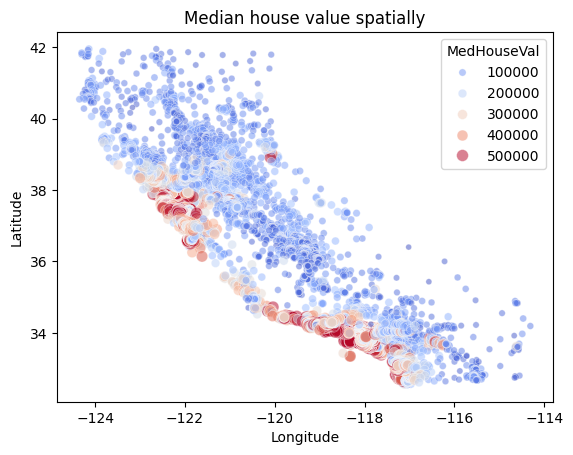

In [ ]:
sns.scatterplot(
    data=df,
    x=df["Longitude"],
    y=df["Latitude"],
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="coolwarm",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", loc="upper right")
plt.title("Median house value spatially")
plt.show()

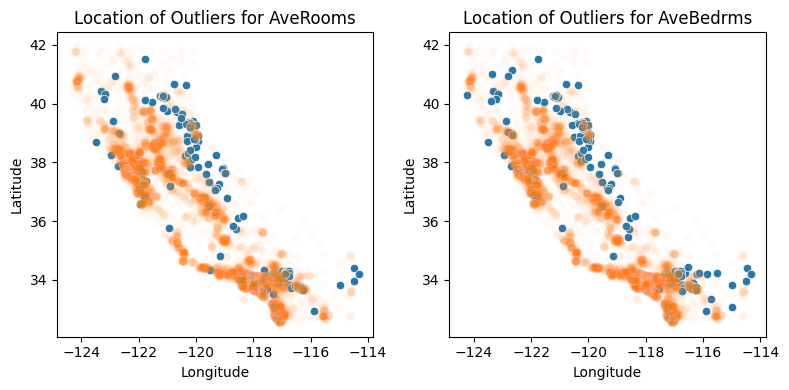

In [199]:
# Lets see where outliers are living
fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distributions
# Scatterplots of Important Features vs Price
outlying_features = ['AveRooms', 'AveBedrms']
for i, feature in enumerate(outlying_features):
    subdf = df[df[feature]>df[feature].quantile(0.99)]
    sns.scatterplot(x=subdf['Longitude'], y=subdf['Latitude'], ax=axes[i])
    sns.scatterplot(x=df['Longitude'], y=df['Latitude'], ax=axes[i], alpha=0.03)

    axes[i].set_title(f"Location of Outliers for {feature}")
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel("Latitude")

plt.tight_layout() 
plt.show()

- As expected it can be seen that Median house value at the coast is higher. 
- Also households with large number of rooms and bedrooms are in the inside

### Correlation Analysis

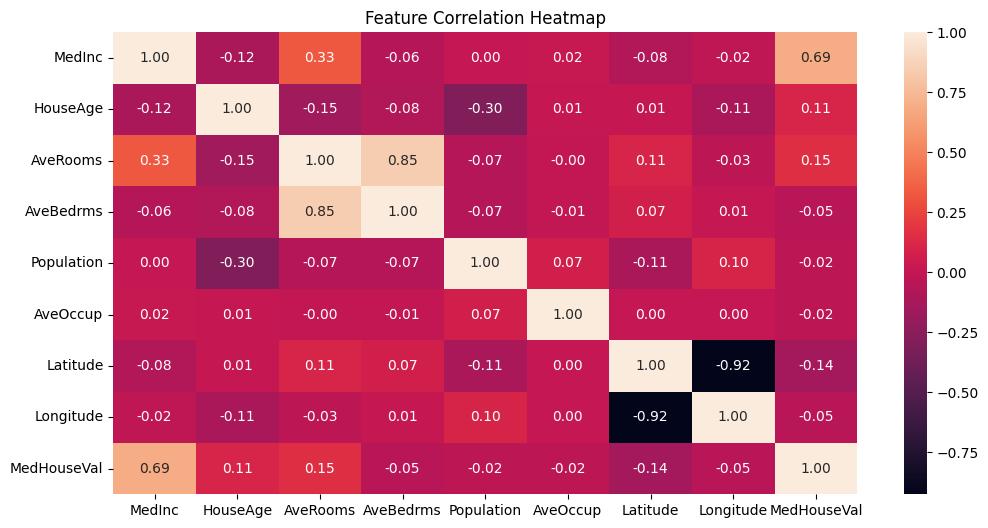

In [200]:
# Feature Correlations
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

## Observations
From the heatmap we can see that 
- AveRooms and AveBedrms are highly related.
- Median Income is highly related to Median House Value

# Feature Engineering
We saw that there are households showing occupancy even more than 100, which is highly unlikely. We can drop it. 
- To drop the extreme outliers let us look at some new variables like Occupancy per room and average bedrooms per room

In [302]:
# Feature Engineering
# y = df["MedHouseVal"]
df['OccupPerRoom'] = df['AveOccup'] / df['AveRooms']
df['BedrmsPerRoom'] = df['AveBedrms'] / df['AveRooms']
df

C:\Users\user\AppData\Local\Temp\ipykernel_37268\2029300811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OccupPerRoom'] = df['AveOccup'] / df['AveRooms']
C:\Users\user\AppData\Local\Temp\ipykernel_37268\2029300811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BedrmsPerRoom'] = df['AveBedrms'] / df['AveRooms']


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,OccupPerRoom,BedrmsPerRoom
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.365909,0.146591
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.338217,0.155797
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.338105,0.129516
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.437991,0.184458
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.347265,0.172096
...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,0.507508,0.224625
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,0.510760,0.215208
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,0.446761,0.215173
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,0.398387,0.219892


In [ ]:
print(df[df['OccupPerRoom']>5].shape[0])
df[df['OccupPerRoom']>5]

15


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,OccupPerRoom,BedrmsPerRoom
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.67500,116.611111,0.222222
4861,0.4999,29.0,2.373272,1.055300,2690.0,12.396313,34.02,-118.28,5.00001,5.223301,0.444660
8874,9.3370,52.0,7.285714,1.214286,1154.0,41.214286,34.06,-118.45,5.00001,5.656863,0.166667
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.54600,16.232342,0.182156
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.62500,8.388158,0.125000
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.25000,27.812500,0.183333
13366,4.2578,36.0,5.258824,1.117647,2886.0,33.952941,33.94,-117.63,1.83300,6.456376,0.212528
15790,4.3958,52.0,2.117647,0.926471,1061.0,15.602941,37.77,-122.40,2.25000,7.368056,0.437500
16420,5.7485,26.0,5.366667,0.900000,1542.0,51.400000,37.89,-121.29,1.62500,9.577640,0.167702
16643,1.0298,20.0,2.398467,0.812261,3574.0,13.693487,35.32,-120.65,3.00000,5.709265,0.338658


There are only 15 data points where Occupancy per room is coming more than 5. We can easily drop them from our analysis

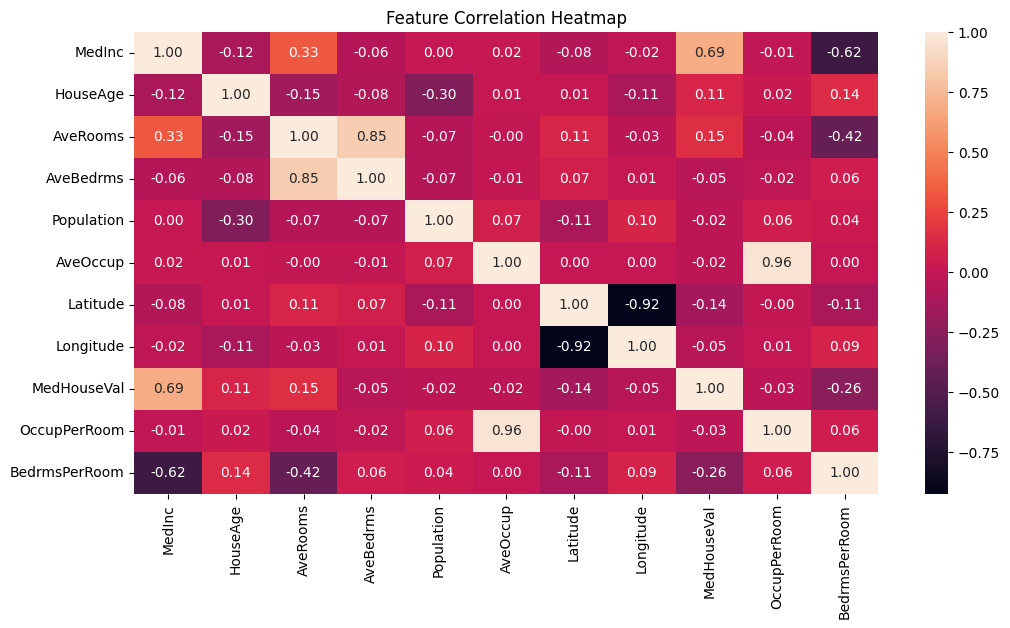

In [203]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

- Occupancy per room and number of rooms are not related. 

So, we will not drop `AveOccup` from our features. We can intuitively drop `AveBedrms` (Average bedrooms) since we have newly created `BedrmsPerRoom` which was related to `AveRooms` (rooms in household)

# Scaling
For scaling our dataset we will first check the skewness in dataset and will only transform those points

In [348]:
df_orig = df.copy()
# df = df.drop(columns=['AveBedrms'])
df = df[df['OccupPerRoom']<5]

In [280]:
X = df.drop(['MedHouseVal'], axis=1)
y = df['MedHouseVal'] # Applying log transformation

In [304]:
skew_df = pd.DataFrame(df.drop(columns='MedHouseVal').columns, columns= ['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(df.drop(columns='MedHouseVal')[feature]))
skew_df['Abs_Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Abs_Skew'].apply(lambda x: True if x > 0.5 else False)
skew_df

,Feature,Skew,Abs_Skew,Skewed
0,MedInc,1.648315,1.648315,True
1,HouseAge,0.060305,0.060305,False
2,AveRooms,20.710667,20.710667,True
3,AveBedrms,31.320763,31.320763,True
4,Population,4.952255,4.952255,True
5,AveOccup,3.757699,3.757699,True
6,Latitude,0.466049,0.466049,False
7,Longitude,-0.298166,0.298166,False
8,OccupPerRoom,3.053083,3.053083,True
9,BedrmsPerRoom,2.157774,2.157774,True


In [305]:
skewed_columns = skew_df[skew_df['Abs_Skew'] > 0.5]['Feature'].values
skewed_columns

array(['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'OccupPerRoom', 'BedrmsPerRoom'], dtype=object)

Skewed columns are 'MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'OccupPerRoom', 'BedrmsPerRoom'
So we will do the scaling for these columns only

### Scaling
We will only scale columns that are skewed

In [284]:
scaler = StandardScaler()
X_scaled = df[skewed_columns]
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled), columns=skewed_columns, index=X.index)

# Combine the scaled columns with the rest of the DataFrame (unchanged columns)
X_non_scaled = df.drop(columns=skewed_columns)
X_non_scaled = X_non_scaled.drop(columns='MedHouseVal')
X_final = pd.concat([X_scaled, X_non_scaled], axis=1)


# Model Training

### Linear Regression

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size= 0.2, random_state= 11)

In [287]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

In [265]:
predictions_lr[0]

np.float64(1.2472122915532111)

In [288]:
X_test.columns

Index(['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'OccupPerRoom', 'BedrmsPerRoom', 'HouseAge', 'Latitude', 'Longitude'],
      dtype='object')

In [260]:
# Save the scaler and regressor to files using pickle
with open('scalers/test_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('models/test_regressor.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [290]:
rmse = root_mean_squared_error(y_test, predictions_lr)
r2 = r2_score(y_test, predictions_lr)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.6660331660210143
R-square: 0.671527293102499


### Decision Tree

In [291]:
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

In [ ]:
# Standard Scaling
scaler = StandardScaler()

# Decision Tree model
model = DecisionTreeRegressor(random_state=11)

# Splitting dataset
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10, 50],
    'min_samples_leaf': [1, 2, 4, 8]
}

model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

MAE: 0.41
RMSE: 0.78
R^2 Score: 0.72


In [293]:
best_model

DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=50, random_state=42)

In [294]:
# Print error for each combination of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]
cv_results['mean_test_score'] = -cv_results['mean_test_score']  # Convert negative MSE to positive MSE
cv_results.sort_values(by='mean_test_score')


,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score
63,None,50,8,0.375148
59,None,50,4,0.380684
47,10,50,8,0.384533
55,None,50,2,0.385862
45,10,5,8,0.387855
...,...,...,...,...
11,3,50,4,0.633217
12,3,2,8,0.633217
13,3,5,8,0.633217
14,3,10,8,0.633217


## Feature importance
- via decision Tree

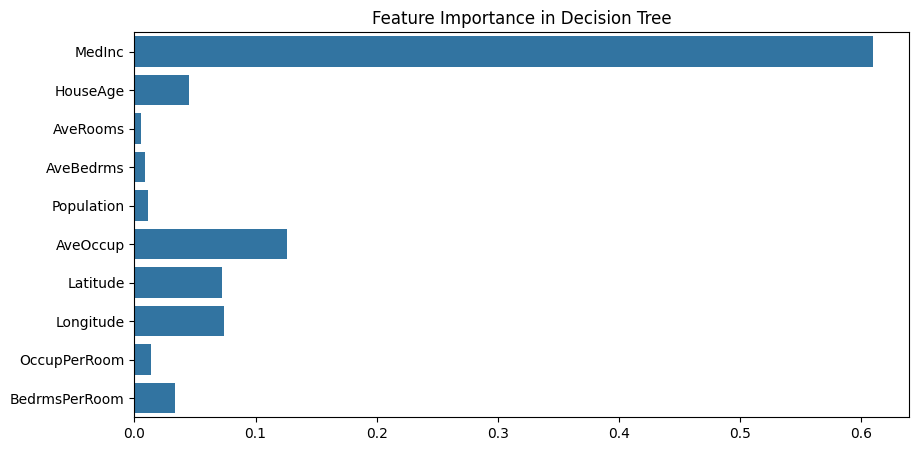

In [295]:
# Feature Importance
feature_names = X.columns.tolist()
feature_importances = best_model.feature_importances_

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance in Decision Tree")
plt.show()

From Decision Tree Regressor, we get that
-  best features to predict house price are Median Income, Average Occupancy, Location, House Age then Average rooms and bedrooms

In [103]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'OccupPerRoom',
       'BedrmsPerRoom'],
      dtype='object')

In [296]:
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [330]:
# Define scaling methods
features_to_not_scale = ['Latitude', 'Longitude', 'MedHouseVal']

scalers = {
    "minmax": MinMaxScaler(),
    "standard": StandardScaler(),
    "log": FunctionTransformer(np.log1p, validate=True)
}

# Define models and hyperparameters
models = {
    "linear_regression": (LinearRegression(), {}),
    "decision_tree": (DecisionTreeRegressor(), {
        "max_depth": [5, 10, None]}),
    "random_forest": (RandomForestRegressor(), {
        "n_estimators": [50, 100], 
        "max_depth": [10, None]}),
    "xgboost": (XGBRegressor(), {
        "n_estimators": [50, 100], 
        "max_depth": [3, 6]}),
    "lightgbm": (LGBMRegressor(),{
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "num_leaves": [31, 50]})
}

# Evaluation function
def evaluate_model(y_true, y_pred):
    return {
        "r2": r2_score(y_true, y_pred),
        "rmse": root_mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred)
    }

results = []

In [344]:
# Create a directory to store models if it doesn't exist
os.makedirs("models", exist_ok=True)
os.makedirs("scalers", exist_ok=True)

stored_scalers_path = {}
stored_scalers = {}
stored_models = {}
stored_models_path = {}

X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=11)

for scaler_name, _ in tqdm(scalers.items()):

    for model_name, (model, params) in tqdm(models.items()):
        print(f"Training {model_name} with {scaler_name} scaling...")

        if scaler_name == "log":
            scaler = FunctionTransformer(np.log1p, validate=True)
        elif scaler_name == "minmax":
            scaler = MinMaxScaler()
        elif scaler_name == "standard":
            scaler = StandardScaler()

        identifier = f"{model_name}_{scaler_name}"
        scaler_path = f"scalers/scaler_{identifier}.pkl"
        model_path = f"models/model_{identifier}.pkl"

        X_train_skewed = X_train[skewed_columns]
        X_test_skewed = X_test[skewed_columns]
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_skewed), columns=X_train_skewed.columns, index=X_train_skewed.index)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_skewed), columns=X_test_skewed.columns, index=X_test_skewed.index)

        X_train_unscaled = X_train.drop(columns = skewed_columns)
        X_test_unscaled = X_test.drop(columns = skewed_columns)
        X_train_full = pd.concat([X_train_scaled, X_train_unscaled], axis='columns')
        X_test_full = pd.concat([X_test_scaled, X_test_unscaled], axis='columns')

        stored_scalers_path[identifier] = scaler_path
        stored_scalers[identifier] = scaler
        
        if params:  # Perform GridSearch if hyperparameters exist
            grid = GridSearchCV(model, params, scoring="r2", cv=5)
            grid.fit(X_train_full, y_train)
            best_model = grid.best_estimator_
            best_params = grid.best_params_
        else:
            best_model = model.fit(X_train_full, y_train)
            best_params = "default"
        
        y_pred = best_model.predict(X_test_full)
        metrics = evaluate_model(y_test, y_pred)

        # Save the trained model
        with open(model_path, "wb") as f:
            pickle.dump(best_model, f)

        with open(scaler_path, "wb") as f:
            pickle.dump(scaler, f)

        stored_models_path[identifier] = model_path
        stored_models[identifier] = model
        
        results.append({
            "scaler": scaler_name,
            "model": model_name,
            "best_params": json.dumps(best_params),
            "r2": metrics["r2"],
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "model_path": model_path,
            "scaler_path": scaler_path
        })
    

  0%|          | 0/3 [00:00<?, ?it/s]

Training linear_regression with minmax scaling...
Training decision_tree with minmax scaling...


Training random_forest with minmax scaling...


Training xgboost with minmax scaling...


Training lightgbm with minmax scaling...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 10
[LightGBM] [Info] Start training from score 2.107273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

 33%|███▎      | 1/3 [00:38<01:17, 38.55s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Training linear_regression with standard scaling...
Training decision_tree with standard scaling...


Training random_forest with standard scaling...


Training xgboost with standard scaling...


Training lightgbm with standard scaling...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 10
[LightGBM] [Info] Start training from score 2.107273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

 67%|██████▋   | 2/3 [01:17<00:39, 39.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training linear_regression with log scaling...
Training decision_tree with log scaling...


Training random_forest with log scaling...


Training xgboost with log scaling...


Training lightgbm with log scaling...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 10
[LightGBM] [Info] Start training from score 2.107273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

100%|██████████| 3/3 [01:57<00:00, 39.12s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Save results to CSV
df_results = pd.DataFrame(results)
# df_results.to_csv("model_results.csv", index=False)
print("Training complete! Results saved to model_results.csv")
df_results


Training complete! Results saved to model_results.csv


,scaler,model,best_params,r2,rmse,mae,model_path,scaler_path
0,minmax,linear_regression,"""default""",0.652968,0.678694,0.496430,models/model_linear_regression_minmax.pkl,scalers/scaler_linear_regression_minmax.pkl
1,minmax,decision_tree,"{""max_depth"": 5}",0.599146,0.729428,0.532130,models/model_decision_tree_minmax.pkl,scalers/scaler_decision_tree_minmax.pkl
2,minmax,random_forest,"{""max_depth"": null, ""n_estimators"": 100}",0.769472,0.553161,0.378074,models/model_random_forest_minmax.pkl,scalers/scaler_random_forest_minmax.pkl
3,minmax,xgboost,"{""max_depth"": 6, ""n_estimators"": 100}",0.794697,0.522020,0.354119,models/model_xgboost_minmax.pkl,scalers/scaler_xgboost_minmax.pkl
4,minmax,lightgbm,"{""learning_rate"": 0.1, ""max_depth"": 5, ""n_esti...",0.803693,0.510454,0.348646,models/model_lightgbm_minmax.pkl,scalers/scaler_lightgbm_minmax.pkl
5,standard,linear_regression,"""default""",0.652968,0.678694,0.496430,models/model_linear_regression_standard.pkl,scalers/scaler_linear_regression_standard.pkl
6,standard,decision_tree,"{""max_depth"": 10}",0.615477,0.714415,0.476317,models/model_decision_tree_standard.pkl,scalers/scaler_decision_tree_standard.pkl
7,standard,random_forest,"{""max_depth"": null, ""n_estimators"": 100}",0.769252,0.553424,0.377995,models/model_random_forest_standard.pkl,scalers/scaler_random_forest_standard.pkl
8,standard,xgboost,"{""max_depth"": 6, ""n_estimators"": 100}",0.794697,0.522020,0.354119,models/model_xgboost_standard.pkl,scalers/scaler_xgboost_standard.pkl
9,standard,lightgbm,"{""learning_rate"": 0.1, ""max_depth"": 5, ""n_esti...",0.801901,0.512779,0.350019,models/model_lightgbm_standard.pkl,scalers/scaler_lightgbm_standard.pkl


In [336]:
df_results.iloc[-1]['best_params']

'{"learning_rate": 0.1, "max_depth": 5, "n_estimators": 100, "num_leaves": 31}'

In [340]:
y.mean()

np.float64(2.068440561939394)

# Best Model
From above models
- Best model - Ligth gbm
- Best scaling transformation - Log based
- best parameters - 
    - "learning_rate": 0.1, 
    - "max_depth": 5, 
    - "n_estimators": 100, 
    - "num_leaves": 31

Minimum error (MAE) - 0.348
Mean of Median House Value (in lakhs of $) - 2.09
Std Deviation of Median House Value (in lakhs of $) - 1.15